In [9]:
from matador import DBQuery, QueryConvexHull
query = DBQuery(composition=['LiAs'], summary=True, biggest=True, subcmd='hull')

5166 results found for query in ajm.
Creating hull from AJM db structures.

Finding biggest calculation set for hull...

     divulge wrench     : matched 122 structures.	-> PBE, 625.0 eV, 0.03 1/A
     divisible hat      : matched 122 structures.	-> PBE, 625.0 eV, 0.03 1/A
    deportment scale    : matched 4921 structures.	-> PBE, 300.0 eV, 0.07 1/A
Matched at least 2/3 of total number, composing hull...
Composing hull from set containing reconcilable twig


────────────────────────────────────────────────────────────
Scanning for suitable Li chemical potential...
Using deceit bun as chem pot for Li
────────────────────────────────────────────────────────────
Scanning for suitable As chemical potential...
Using assimilate bubble as chem pot for As
────────────────────────────────────────────────────────────
Constructing binary hull...
142 structures within 0.03 eV of the hull with chosen chemical potentials.
─────────────────────────────────────────────────────────────────────────────────────────────────────────────
           ID            !?!   Pressure   Volume/fu   Hull dist./atom  Space group  Formula    # fu   Prov.  
─────────────────────────────────────────────────────────────────────────────────────────────────────────────
*       deceit bun              -0.005      21.893        0.00000          Cmcm        Li       2     AIRSS  
*    conspirator salt           0.001       66.333        0.00000          Pnma      AsLi3      4    

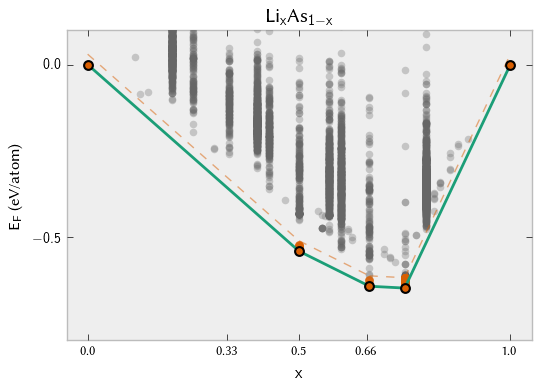

In [10]:
hull = QueryConvexHull(query, hull_cutoff=3e-2)

In [15]:
query2 = DBQuery(composition=['[X]'], partial_formula=True, summary=True, subcmd='query', top=-1)

141043 results found for query in ajm.
─────────────────────────────────────────────────────────────────────────────────────────────────────────────
           ID            !?!   Pressure   Volume/fu     Enthalpy/fu    Space group  Formula    # fu   Prov.  
─────────────────────────────────────────────────────────────────────────────────────────────────────────────
   diplomatist sheet            -0.056      43.471      -9587.72180        P4mm       HfIn      2     AIRSS  
     aspire cellar              0.031       28.735      -3365.20707       P3_121       Se       3     AIRSS  
    demonstrate soda            -0.018      22.641      -2962.91180        C2/m        As       2      OQMD  
      canary look               -0.021     202.390      -20382.51995       P2_1      Se6Li      2     SWAPS  
       rotate day               -0.055     308.637      -23939.30800        I4       Se7Li2     2     SWAPS  
  paraphernalia ground          0.037       89.597      -10287.45342      P-3c1  

In [ ]:
%time
uniq_list, same_list, refined_list, shifted_list = spg_uniq(query2.cursor,
                                                            symprec=1e-2,
                                                            latvecprec=1e-2,
                                                            posprec=1e-2)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


In [3]:
def spg_uniq(cursor, method='standard', symprec=1e-2, latvecprec=1e-2, posprec=1e-4):
    """ Use spglib to find duplicate structures in a cursor. 
    Returns uniq_list and same_list.
    
    * cursor     : list of matador structure docs.
    * symprec    : spglib symmetry precision for cell standardisation.
    * latvecprec : tolerance on lattice vectors.
    * posprec    : tolerance on fractional atomic positions.
    * uniq_list  : list of indices of the unique structures in cursor.
    * same_list  : list of pairs indices of duplicate structures.    
    """
    
    from utils.cell_utils import doc2spg
    import spglib as spg
    import numpy as np

    spg_cursor = list()
    for doc in cursor:
        spg_cursor.append(doc2spg(doc))

    refined_list = []
    for crystal in spg_cursor:
        refined_list.append(spg.standardize_cell(crystal, to_primitive=False, no_idealize=False, symprec=symprec))
    for i in range(len(refined_list)):
        for j in range(len(refined_list[i][1])):
            for k in range(len(refined_list[i][1][j])):
                if refined_list[i][1][j][k] > 1-1e-10:
                    refined_list[i][1][j][k] = 0.0
    for i in range(len(refined_list)):
        refined_list[i] = (refined_list[i][0],
                           refined_list[i][1][np.argsort(refined_list[i][1][:, 0])],
                           refined_list[i][2][np.argsort(refined_list[i][1][:, 0])])
    uniq_list = np.arange(0, len(spg_cursor))
    same_list = []
    shift_list = []
    for i in range(len(spg_cursor)):
        for j in range(i+1, len(spg_cursor)):
            if cursor[i]['stoichiometry'] == cursor[j]['stoichiometry']:
                if np.allclose(refined_list[i][0], refined_list[j][0], atol=latvecprec, rtol=0):
                    if np.allclose(refined_list[i][1], refined_list[j][1], atol=posprec, rtol=0):
                        same_list.append((i, j))
                    else:
                        for dim in range(3):
                            if not rigid_shift(refined_list[i], refined_list[j], dim, posprec):
                                    break
                            elif dim == 3:
                                same_list.append((i, j))
                                shift_list.append((i, j, dim))
                            break
    dupes = list(set([pair[1] for pair in same_list]))
    uniq_list = np.delete(uniq_list, dupes)
    print(len(dupes), 'duplicates found and removed.')
    print(len(shift_list), 'of which were shifted cells.')
    return uniq_list, same_list, refined_list, shift_list

In [7]:
def rigid_shift(structA, structB, dim, posprec):
    import numpy as np
    assert(len(structA[2]) == len(structB[2]))
    shift_array = structA[1][:, dim] - structB[1][:, dim]
    # if trivial zero shift, return True
    if np.all((np.abs(shift_array)) < 1e-4):
        return True
    shift_array[np.where(shift_array < 0)] += 1
    # if nontrivial shift, return True
    return np.all((np.abs(np.diff(shift_array)) < 1e-4))